In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pyarrow
import warnings
warnings.filterwarnings('ignore')

# Critical difference imports
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import scipy.stats as ss

In [2]:
FROM_RAW_DATA = False
if FROM_RAW_DATA:
    sys.path.append('../../src')
    sys.path.append('../')
    import ipynb_utils
    df = ipynb_utils.load_and_process_synetune('real-1')
    df = ipynb_utils.fill_missing_trials(df, verbose=True)
    df.rename(index={'RandomSearch': 'RS', 'SyncBOHB': 'BOHB'}, inplace=True)
else:
    df = pd.read_feather('../../results/real-1.feather')

In [3]:
SERIALIZE = False
if SERIALIZE:
    sub_df = df[['epoch', 'val_loss','train_loss', 'elapsed_time', 'experiment_tag', 'metric_mode', 'optimization_metric', 'cumulative', 'regret', 'max_num_evaluations']]
    sub_df.to_feather('../../results/real-1.feather')

In [4]:
# Summary of runs - see if none are missing
df_reset = df.reset_index()
df_pivot = df_reset.pivot_table(index=['benchmark', 'repeat'], columns='algorithm', values='trial', aggfunc=np.max, fill_value=0)
df_pivot.columns = [col for col in df_pivot.columns]
df_pivot = df_pivot.reset_index(['benchmark', 'repeat'])
df_pivot.tail(30)

,benchmark,repeat,ASHA,BOHB,DyHPO,HyperTune,RS
40,svhn_residual,40,801,801,801,801,801
41,svhn_residual,41,801,801,801,801,801
42,svhn_residual,42,801,801,801,801,801
43,svhn_residual,43,801,801,801,801,801
44,svhn_residual,44,801,801,801,801,801
45,svhn_residual,45,801,801,801,801,801
46,svhn_residual,46,801,801,801,801,801
47,svhn_residual,47,801,801,801,801,801
48,svhn_residual,48,801,801,801,801,801
49,svhn_residual,49,801,801,801,801,801


In [5]:
# Benchmarks summary table
# Compute average runtime for each benchmark with random search
save = False

df_random = df.xs('RS', level='algorithm')
df_random = df_random.groupby(['benchmark', 'repeat']).last() #['elapsed_time'].mean()
times = df_random.groupby('benchmark')['elapsed_time'].mean()
times = (times / 60).round(0).astype(int).rename('Avg runtime (min)')
times = times.to_frame()
times['Budget'] = 0
times['Epochs'] = 0

benchmark_names = df.index.levels[0]

for benchmark_name in benchmark_names:
    tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
    budget = tmp['max_num_evaluations'].iloc[0]
    times.loc[benchmark_name, 'Epochs'] = budget/20
    times.loc[benchmark_name, 'Budget'] = budget
    print(f"Calculating {benchmark_name}")

times.columns = [r'Avg.\ runtime (min)', 'Budget', 'Epochs']
times = times[['Epochs', 'Budget', r'Avg.\ runtime (min)']]
times.index.name = 'Benchmark'
# Rename index names
times.index = times.index.str.replace('_', ' ')

print(times)

# 2. Convert to latex and save
caption = 'Summary of the real-world experiments. A total of 7 experiments were performed. The columns describe the maximal number of epochs for training a single configuration, the total budget for the run of an experiment in terms of epochs, and the average runtime of each experiment in minutes. The average runtime is calculated just from the random search runs. Note that cifar10 sequential and svhn sequential neural networks were trained on a CPU, all other experiments used a GPU for training.'
latex_table = times.to_latex()
latex_table_custom = times.to_latex(index=True,
        caption=caption,
        label='tab:real_bench_summary',
        column_format='lccc',
        #position='H',
        escape=False)
print(latex_table)

if save:
    with open(f'../../thesis/tables/real_bench_summary.tex', 'w') as file:
        file.write(latex_table_custom)

Calculating cifar10_residual
Calculating cifar10_simple
Calculating ptbxl_rnn
Calculating ptbxl_xResNet1d
Calculating svhn_residual
Calculating svhn_simple
Calculating xray_densenet
                  Epochs  Budget  Avg.\ runtime (min)
Benchmark                                            
cifar10 residual      50    1000                  561
cifar10 simple        75    1500                  487
ptbxl rnn             50    1000                  290
ptbxl xResNet1d       40     800                  134
svhn residual         40     800                  459
svhn simple           70    1400                 1825
xray densenet         20     400                  955
\begin{tabular}{lrrr}
\toprule
 & Epochs & Budget & Avg.\ runtime (min) \\
Benchmark &  &  &  \\
\midrule
cifar10 residual & 50 & 1000 & 561 \\
cifar10 simple & 75 & 1500 & 487 \\
ptbxl rnn & 50 & 1000 & 290 \\
ptbxl xResNet1d & 40 & 800 & 134 \\
svhn residual & 40 & 800 & 459 \\
svhn simple & 70 & 1400 & 1825 \\
xray densenet & 2

Plotting cifar10_residual
Zoomed y-axis limits: 0.012154294032023297 - 0.025448811256671505


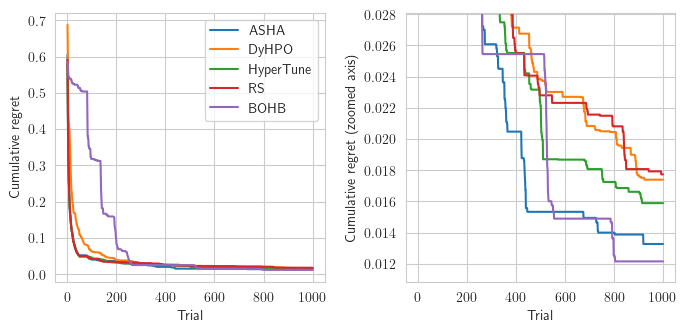

Plotting cifar10_simple
Zoomed y-axis limits: 0.009402390438247015 - 0.24653386454183268


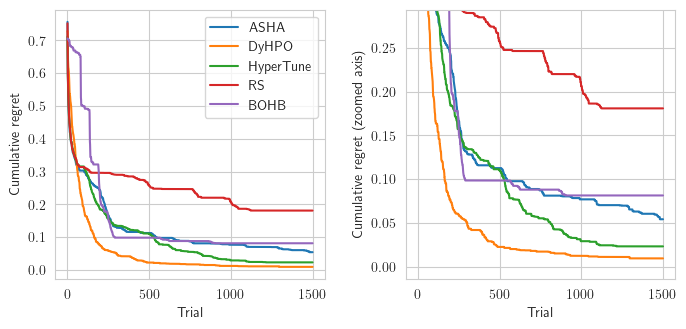

Plotting ptbxl_rnn
Zoomed y-axis limits: 0.02799109399029842 - 0.05554774343305937


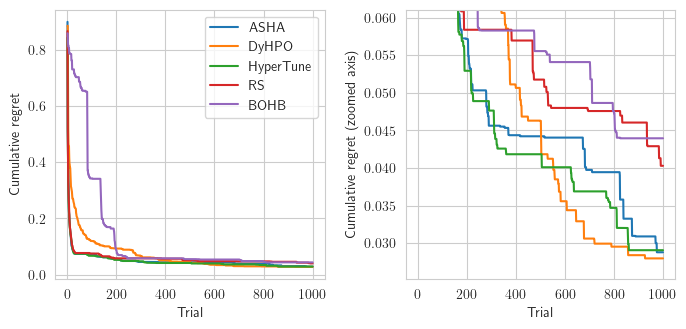

Plotting ptbxl_xResNet1d
Zoomed y-axis limits: 0.013670332208895514 - 0.05453738194963601


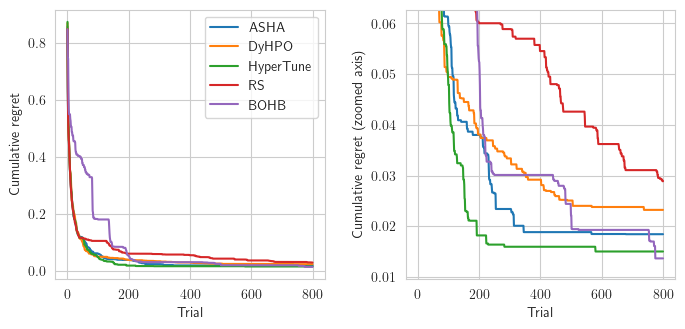

Plotting svhn_residual
Zoomed y-axis limits: 0.00305444238099873 - 0.01959241520867929


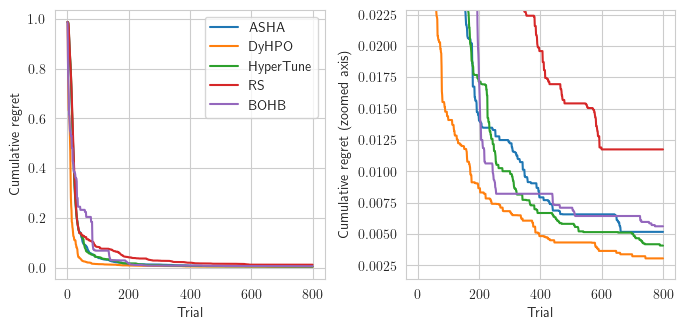

Plotting svhn_simple
Zoomed y-axis limits: 0.006532528504359517 - 0.12882629107981222


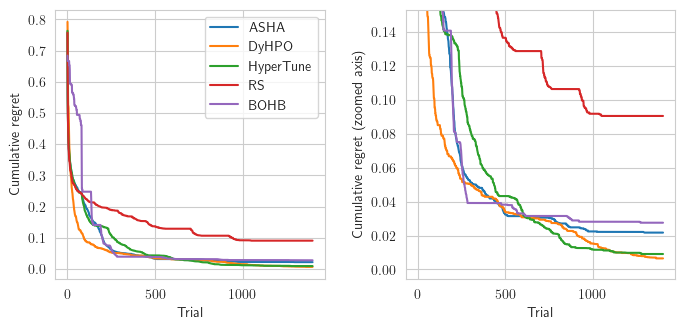

Plotting xray_densenet
Zoomed y-axis limits: 0.029491992977826183 - 0.07225857629354328


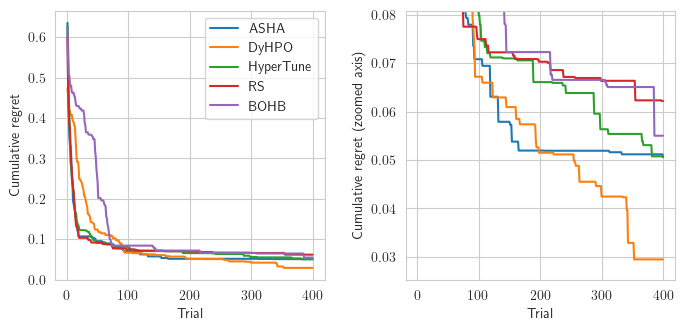

In [6]:
# Plot regret double plots
logx = False
logy = False
save = True

plt.rcParams.update({
    "text.usetex": True,
   # 'text.latex.preamble': '\\usepackage{libertine}'
  #  "font.family": "Helvetica"
})

# Filter out rows with trial > df['max_num_evaluations'] for each benchmark
for benchmark_name in df.index.get_level_values('benchmark').unique():
    print(f'Plotting {benchmark_name}')
    tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
    budget = tmp['max_num_evaluations'].iloc[0]
    # Limit the trials
    if budget is not None:
        tmp = tmp[tmp.index.get_level_values('trial') <= budget]

    # Set properties of the plot
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
    fig.subplots_adjust(wspace=0.3)
    #plt.axes().set_xscale('log')
    #plt.axes().set_yscale('log')

    err_bar=None
    #err_bar='ci'
    sns.lineplot(data=tmp, x='trial', y='regret', hue='algorithm', palette="tab10", dashes=False, errorbar=err_bar, ax=axes[0])

    axes[0].set_xlabel('Trial')
    axes[0].set_ylabel('Cumulative regret')

    if logx:
        axes[0].set_xscale('log')
    if logy:
        axes[0].set_yscale('log')

    # Set properties of the second plot
    mid_budget = budget // 2 if budget is not None else None
    if mid_budget is not None:
        tmp_zoomed = tmp[tmp.index.get_level_values('trial') == mid_budget]
        tmp_zoomed  = tmp_zoomed['regret']
        tmp_zoomed = tmp_zoomed.groupby(['algorithm']).mean()
        tmp_zoomed = tmp_zoomed[~(tmp_zoomed.index.get_level_values('algorithm')=='RandomSearch')]

    sns.lineplot(data=tmp, x='trial', y='regret', hue='algorithm', palette="tab10", dashes=False, errorbar=err_bar, ax=axes[1], legend=False)

    axes[1].set_xlabel('Trial')
    axes[1].set_ylabel('Cumulative regret (zoomed axis)')

    if logx:
        axes[1].set_xscale('log')
    if logy:
        axes[1].set_yscale('log')


    # Adjust the y-axis limits to zoom in
    #print(tmp['regret'])
    at_max_budget = tmp[tmp.index.get_level_values('trial')==budget]
    grouped = at_max_budget.groupby(['algorithm'])['regret'].mean()

    #print(at_budget)
    min_y = tmp[tmp.index.get_level_values('trial')==budget].groupby(['algorithm'])['regret'].mean().min()

    max_y = tmp_zoomed.max()
    #max_y = -0.65
    #min_y = -0.72
    spacing = (max_y - min_y) * 0.1
    axes[1].set_ylim(min_y-spacing, max_y+2*spacing)
    print(f'Zoomed y-axis limits: {min_y} - {max_y}')

    # plt.title(f'Cumulative best {metric}')
    axes[0].legend()
    plt.rcParams['savefig.format'] = 'pdf'
    if save:
        plt.savefig(f'../../thesis/img/real_exp/{benchmark_name}_regret_plot', bbox_inches='tight')
    plt.show()

Plotting cifar10_residual
Zoomed y-axis limits: 0.8869640000000001 - 0.912906


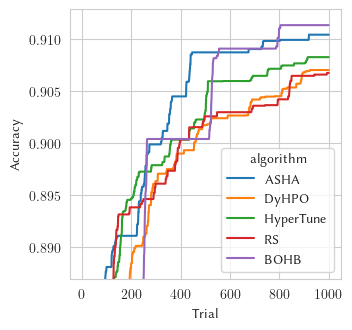

Plotting cifar10_simple
Zoomed y-axis limits: 0.583816 - 0.809984


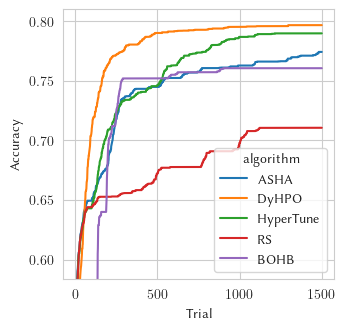

Plotting ptbxl_rnn
Zoomed y-axis limits: 0.9248552224332472 - 0.9303686439533871


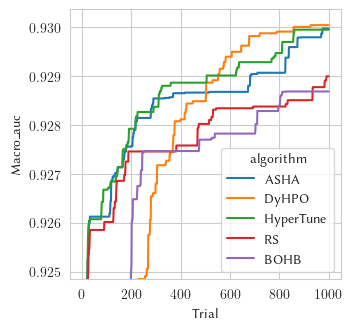

Plotting ptbxl_xResNet1d
Zoomed y-axis limits: 0.9147529943417306 - 0.9273314842270892


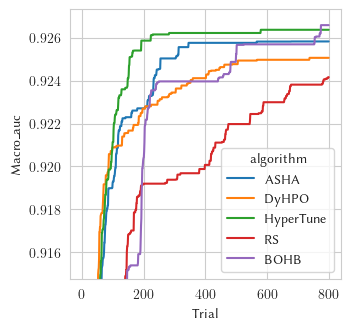

Plotting svhn_residual
Zoomed y-axis limits: 0.9263498770743699 - 0.9711551167793486


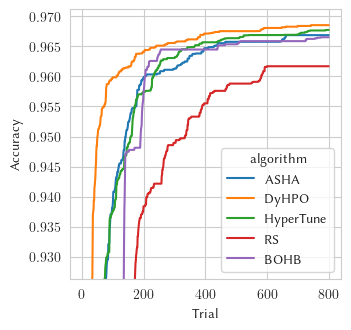

Plotting svhn_simple
Zoomed y-axis limits: 0.8804171788567917 - 0.951977566072526


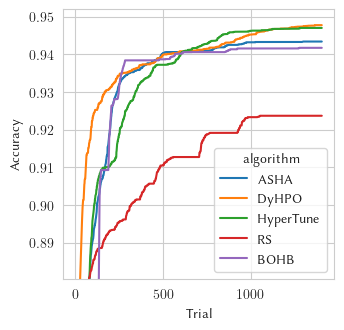

Plotting xray_densenet
Zoomed y-axis limits: 0.7198564046443798 - 0.7495965122618257


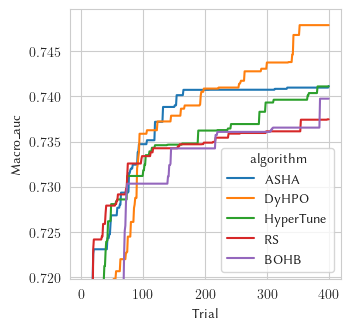

In [7]:
# Plot single plots
logx = False
logy = False
save = True

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': '\\usepackage{libertine}'
})

# Filter out rows with trial > df['max_num_evaluations'] for each benchmark
for benchmark_name in df.index.get_level_values('benchmark').unique():
    print(f'Plotting {benchmark_name}')
    tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
    budget = tmp['max_num_evaluations'].iloc[0]
    mode = tmp['metric_mode'].iloc[0]
    # Limit the trials
    if budget is not None:
        tmp = tmp[tmp.index.get_level_values('trial') <= budget]

    # Set properties of the plot
    plt.figure(figsize=(3.5, 3.5))
    sns.set_style("whitegrid")

    err_bar=None
    #err_bar='ci'
    sns.lineplot(data=tmp, x='trial', y='cumulative', hue='algorithm', palette="tab10", dashes=False, errorbar=err_bar)
    plt.xlabel('Trial')
    plt.ylabel(tmp['optimization_metric'].iloc[0].capitalize())

    # Set properties of the second plot
    budget_frac = 0.3
    mid_budget = int(budget * budget_frac) if budget is not None else None
    if mid_budget is not None:
        tmp_zoomed = tmp[tmp.index.get_level_values('trial') == mid_budget]
        tmp_zoomed  = tmp_zoomed['cumulative']
        tmp_zoomed = tmp_zoomed.groupby(['algorithm']).mean()

    at_max_budget = tmp[tmp.index.get_level_values('trial')==budget]
    grouped = at_max_budget.groupby(['algorithm'])['cumulative'].mean()
    max_means = tmp[tmp.index.get_level_values('trial')==budget].groupby(['algorithm'])['cumulative'].mean()

    if mode == 'max':
        max_y = max_means.max()
        min_y = tmp_zoomed.min()
    else:
        min_y = max_means.min()
        max_y = tmp_zoomed.max()


    spacing = (max_y - min_y) * 0.1

    if mode == 'max':
        max_y = max_y+spacing
        min_y = min_y-6*spacing
    else:
        max_y = max_y+6*spacing
        min_y = min_y-spacing

    plt.ylim(min_y, max_y)
    print(f'Zoomed y-axis limits: {min_y} - {max_y}')

    plt.rcParams['savefig.format'] = 'pdf'
    if save:
        plt.savefig(f'../../thesis/img/real_exp/{benchmark_name}_plot', bbox_inches='tight')
    plt.show()

In [8]:
save = True
def format_ci(stats_tuple):
    ci_lower, ci_upper = stats_tuple
    return f"[{ci_lower:.3f}, {ci_upper:.3f}]"

def get_ci(data):
    stats_full = data.groupby(['algorithm'])['cumulative'].agg(['mean', 'sem', 'std'])

    stats_full['ci95 hi'] = stats_full['mean'] + 1.96* stats_full['sem']
    stats_full['ci95 lo'] = stats_full['mean'] - 1.96* stats_full['sem']
    stats_full['ci'] = stats_full.apply(lambda x: format_ci((x['ci95 lo'], x['ci95 hi'])), axis=1)
    stats_full.drop(columns=['sem','std', 'ci95 lo', 'ci95 hi'], inplace=True)
    return stats_full

benchmark_name = "cifar10_simple"
print(f'Benchmark: {benchmark_name}')
tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
tmp.rename(index={'RandomSearch': 'RS'}, inplace=True, level='algorithm')
budget = tmp['max_num_evaluations'].iloc[0]
# Limit the trials
if budget is not None:
    tmp = tmp[tmp.index.get_level_values('trial') <= budget]

# 1. Prepare the table
last = tmp[tmp.index.get_level_values('trial') == budget]
mid_budget = tmp[tmp.index.get_level_values('trial') == budget // 2]
stats_full = get_ci(last)
stats_mid = get_ci(mid_budget)


stats_full.rename(columns={'mean': 'mean', 'ci': 'ci full'}, inplace=True)
stats_mid.rename(columns={'mean': 'mean mid', 'ci': 'ci mid'}, inplace=True)

stats = stats_full.join(stats_mid, how='outer')

#print(stats_full)
#print(stats_mid)
#print(stats)


stats_full.rename(columns={'ci full': r"\SI{95}{\percent} CI"}, inplace=True)

# 2. Convert to latex and save
caption = 'Table with results.'
latex_table = stats_full.to_latex(float_format="%.4f")
latex_table_custom = stats_full.to_latex(index=True,
        #caption=caption,
        #label='tab:res_{benchmark_name}',
        column_format='lcccc',
        float_format="%.4f",
        escape=False)
print(latex_table)

if save:
    with open(f'../../thesis/tables/{benchmark_name}_results_short.tex', 'w') as file:
        file.write(latex_table_custom)




Benchmark: cifar10_simple
\begin{tabular}{lrl}
\toprule
 & mean & \SI{95}{\percent} CI \\
algorithm &  &  \\
\midrule
ASHA & 0.7742 & [0.768, 0.780] \\
BOHB & 0.7605 & [0.750, 0.771] \\
DyHPO & 0.7967 & [0.795, 0.798] \\
HyperTune & 0.7898 & [0.781, 0.799] \\
RS & 0.7105 & [0.683, 0.739] \\
\bottomrule
\end{tabular}



In [9]:
# Print all columns
print(df.columns)

Index(['epoch', 'val_loss', 'train_loss', 'elapsed_time', 'experiment_tag',
       'metric_mode', 'optimization_metric', 'cumulative', 'regret',
       'max_num_evaluations'],
      dtype='object')


Benchmark: cifar10_residual


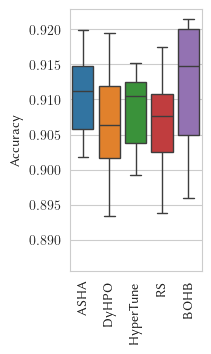

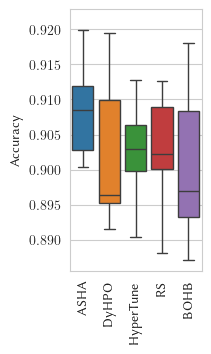

Benchmark: cifar10_simple


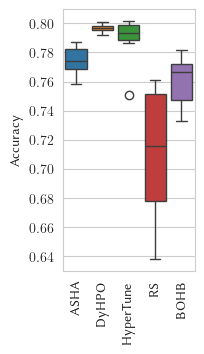

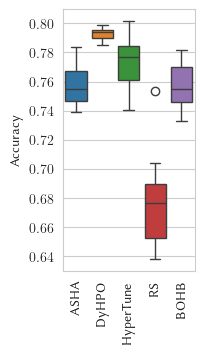

Benchmark: ptbxl_rnn


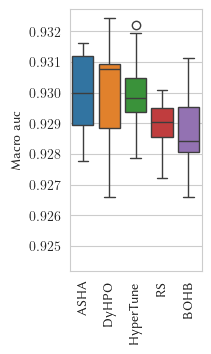

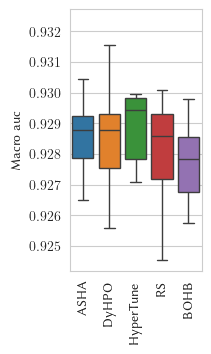

Benchmark: ptbxl_xResNet1d


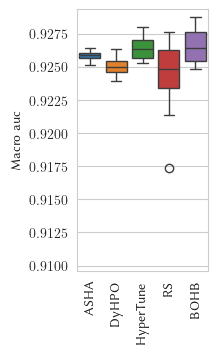

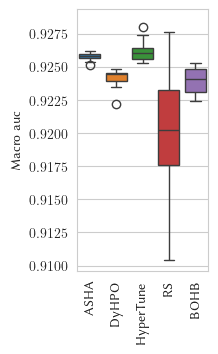

Benchmark: svhn_residual


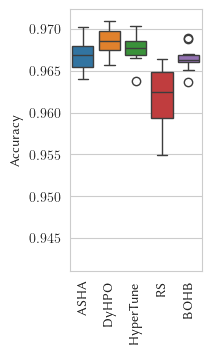

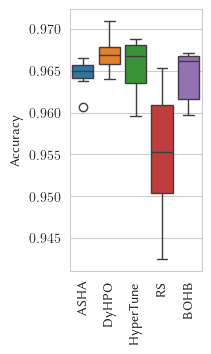

Benchmark: svhn_simple


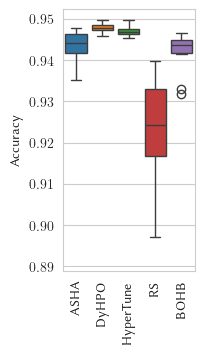

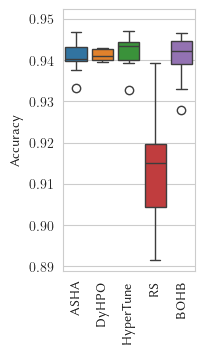

Benchmark: xray_densenet


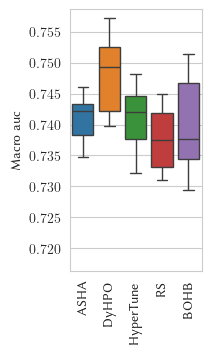

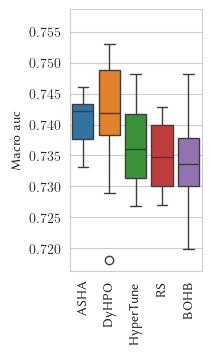

In [10]:
save = True
plot_width = 1.7
plot_height = 3.4

for benchmark_name in df.index.get_level_values('benchmark').unique():
    print(f'Benchmark: {benchmark_name}')
    tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
    tmp = tmp.rename(index={'RandomSearch': 'RS'}, level='algorithm')
    metric_name = tmp['optimization_metric'].iloc[0]
    metric_name = metric_name.capitalize().replace('_', ' ')
    budget = tmp['max_num_evaluations'].iloc[0]
    # Limit the trials
    if budget is not None:
        tmp = tmp[tmp.index.get_level_values('trial') <= budget]
        last = tmp[tmp.index.get_level_values('trial') == budget]
        mid_budget = tmp[tmp.index.get_level_values('trial') == budget // 2]
        sns.set_style("whitegrid")

        # Get the ylims so that the plots are comparable
        plt.figure(figsize=(plot_width, plot_height))
        sns.boxplot(data=last, x='algorithm', y='cumulative', palette="tab10", hue='algorithm')
        ymin_full, ymax_full = plt.ylim()
        plt.close()

        plt.figure(figsize=(plot_width, plot_height))
        sns.boxplot(data=mid_budget, x='algorithm', y='cumulative', palette="tab10", hue='algorithm')
        ymin_half, ymax_half = plt.ylim()
        plt.close()

        ymin = min(ymin_full, ymin_half)
        ymax = max(ymax_full, ymax_half)

        # Plot the boxplots
        plt.figure(figsize=(plot_width, plot_height))
        sns.boxplot(data=last, x='algorithm', y='cumulative', palette="tab10", hue='algorithm')
        ymin_full, ymax_full = plt.ylim()
        # Rotate labels
        plt.xticks(rotation=90)
        plt.xlabel('')
        plt.ylabel(metric_name)
        plt.ylim(ymin, ymax)
        plt.rcParams['savefig.format'] = 'pdf'
        if save:
            plt.savefig(f'../../thesis/img/real_exp/{benchmark_name}_boxplot_full', bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(plot_width, plot_height))
        sns.set_style("whitegrid")
        sns.boxplot(data=mid_budget, x='algorithm', y='cumulative', palette="tab10", hue='algorithm')
        ymin_half, ymax_half = plt.ylim()
        # Rotate labels
        plt.xticks(rotation=90)
        plt.xlabel('')
        plt.ylabel(metric_name)
        plt.ylim(ymin, ymax)
        plt.rcParams['savefig.format'] = 'pdf'
        if save:
            plt.savefig(f'../../thesis/img/real_exp/{benchmark_name}_boxplot_half', bbox_inches='tight')
        plt.show()



Benchmark: cifar10_residual
Full
Kruskal-Wallis test for cifar10_residual,  significant: False, pvalue: 0.5087443026264289


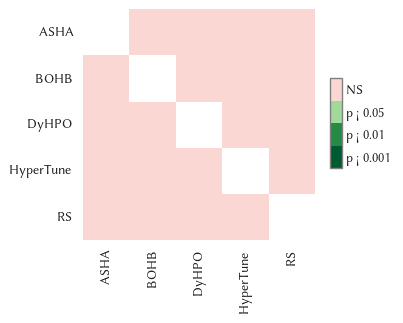

Mid
Kruskal-Wallis test for cifar10_residual,  significant: False, pvalue: 0.20388725984249437


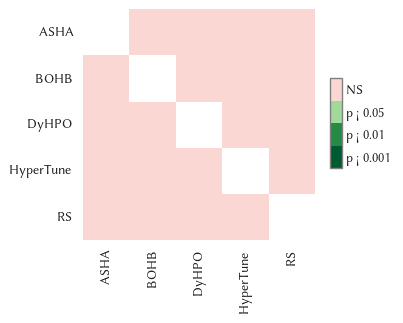

Benchmark: cifar10_simple
Full
Kruskal-Wallis test for cifar10_simple,  significant: True, pvalue: 1.342956515975993e-07


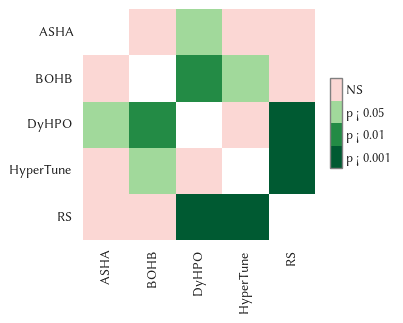

Mid
Kruskal-Wallis test for cifar10_simple,  significant: True, pvalue: 5.842326907484987e-07


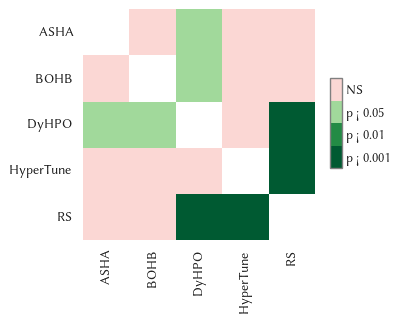

Benchmark: ptbxl_rnn
Full
Kruskal-Wallis test for ptbxl_rnn,  significant: False, pvalue: 0.13097330423595036


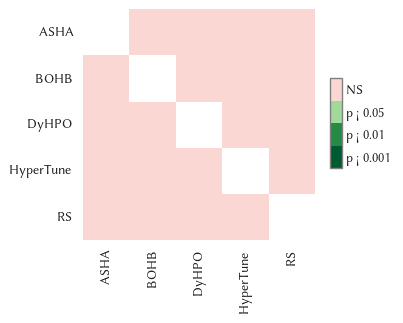

Mid
Kruskal-Wallis test for ptbxl_rnn,  significant: False, pvalue: 0.3625555797062981


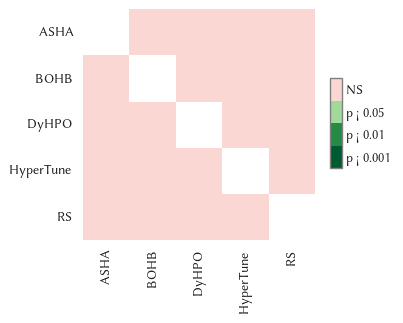

Benchmark: ptbxl_xResNet1d
Full
Kruskal-Wallis test for ptbxl_xResNet1d,  significant: True, pvalue: 0.007471332326948249


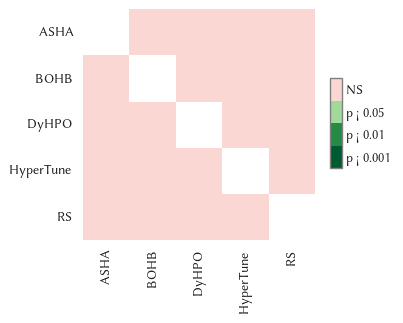

Mid
Kruskal-Wallis test for ptbxl_xResNet1d,  significant: True, pvalue: 1.68543121849828e-06


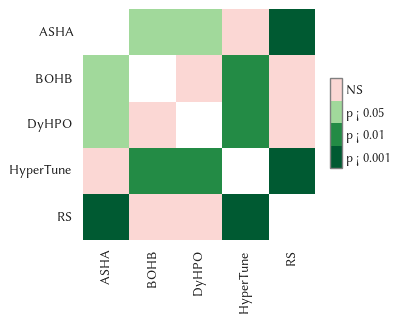

Benchmark: svhn_residual
Full
Kruskal-Wallis test for svhn_residual,  significant: True, pvalue: 0.00014471177137898695


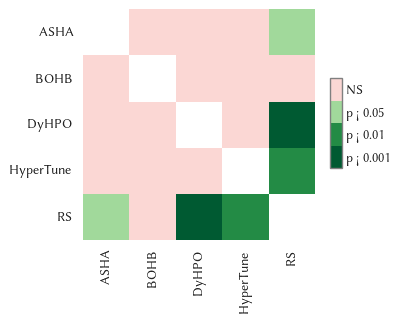

Mid
Kruskal-Wallis test for svhn_residual,  significant: True, pvalue: 0.0003963169676528673


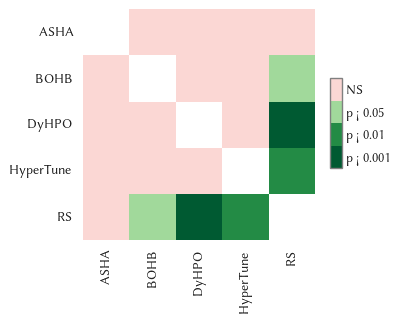

Benchmark: svhn_simple
Full
Kruskal-Wallis test for svhn_simple,  significant: True, pvalue: 2.676747375100197e-07


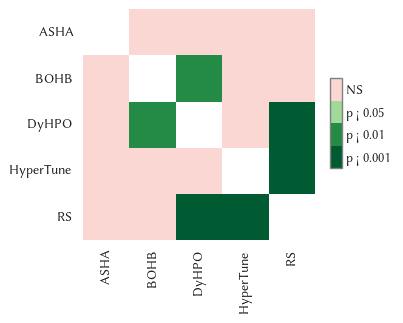

Mid
Kruskal-Wallis test for svhn_simple,  significant: True, pvalue: 0.0001473587201247785


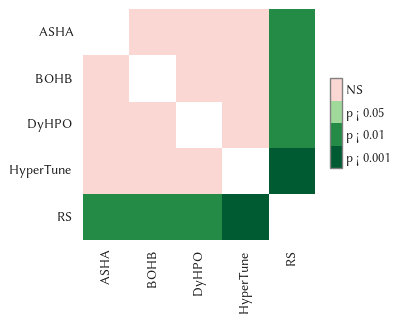

Benchmark: xray_densenet
Full
Kruskal-Wallis test for xray_densenet,  significant: True, pvalue: 0.01899747669859666


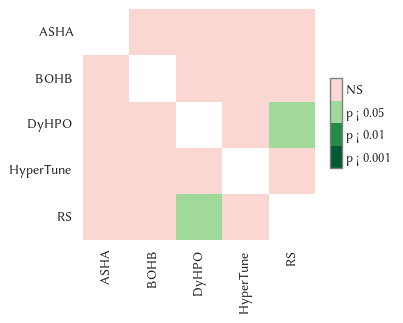

Mid
Kruskal-Wallis test for xray_densenet,  significant: False, pvalue: 0.08973410495240174


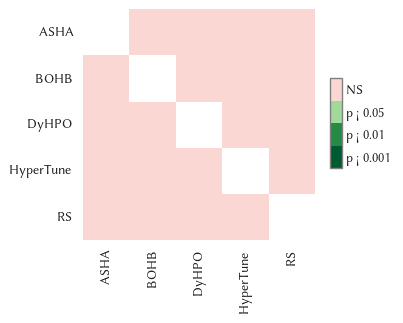

In [11]:
save = False

for benchmark_name in df.index.get_level_values('benchmark').unique():
    print(f'Benchmark: {benchmark_name}')
    tmp = df.loc[(benchmark_name, slice(None), slice(None), slice(None))]
    tmp = tmp.rename(index={'RandomSearch': 'RS'}, level='algorithm')
    budget = tmp['max_num_evaluations'].iloc[0]
    # Limit the trials
    if budget is not None:
        tmp = tmp[tmp.index.get_level_values('trial') <= budget]
        last = tmp[tmp.index.get_level_values('trial') == budget]
        mid_budget = tmp[tmp.index.get_level_values('trial') == budget // 2]

        # Select only 'cumulative' column
        last = last['cumulative']
        mid = mid_budget['cumulative']
        print("Full")
        # Kruskal-Wallis test
        kruskal = ss.kruskal(*[last.loc[alg] for alg in last.index.get_level_values('algorithm').unique()])
        print(f'Kruskal-Wallis test for {benchmark_name},  significant: {kruskal.pvalue < 0.05}, pvalue: {kruskal.pvalue}')

        # Dunn's post-hoc test
        test = sp.posthoc_dunn(last.reset_index(), val_col='cumulative', group_col='algorithm', p_adjust='holm')

        plt.figure(figsize=(3, 3))
        # get axes
        ax = plt.gca()
        sp.sign_plot(test, ax=ax)
        plt.show()
        plt.close()

        print("Mid")
        # Kruskal-Wallis test
        kruskal = ss.kruskal(*[mid.loc[alg] for alg in last.index.get_level_values('algorithm').unique()])
        print(f'Kruskal-Wallis test for {benchmark_name},  significant: {kruskal.pvalue < 0.05}, pvalue: {kruskal.pvalue}')

        # Dunn's post-hoc test
        test = sp.posthoc_dunn(mid.reset_index(), val_col='cumulative', group_col='algorithm', p_adjust='holm')

        plt.figure(figsize=(3, 3))
        # get axes
        ax = plt.gca()
        sp.sign_plot(test, ax=ax)
        plt.show()
        plt.close()




In [12]:
palette = sns.color_palette("tab10")
colors = { 'ASHA': palette[0],
          'DyHPO': palette[1],
          'HyperTune': palette[2],
          'RS': palette[3],
          'BOHB': palette[4],}

In [13]:
# 2. Calculate ranks for each benchmark at specific budget
benchmark_names = df.index.get_level_values('benchmark').unique().tolist()
algos = df.index.get_level_values('algorithm').unique()

frac = 1.0
avgs = []
ranks = []
means = []
for benchmark_name in benchmark_names:
    print(f"Calculating {benchmark_name}")
    bench_df = df.loc[(benchmark_name, algos, slice(None), slice(None))]
    bench_df = bench_df.reset_index(level='trial')

    budget = bench_df['max_num_evaluations'].iloc[0]

    # Calculate cumulative metric and ranks
    filtered = bench_df[bench_df['trial'] == frac * budget]
    ranks_df = filtered.groupby('algorithm')['cumulative'].mean().rank(ascending=False)
    ranks_df.rename(f'{benchmark_name}', inplace=True)
    cum_mean = filtered.groupby('algorithm')['regret'].mean()
    cum_mean.rename(f'{benchmark_name}', inplace=True)
    ranks.append(ranks_df)
    means.append(cum_mean)
ranks = pd.concat(ranks, axis=1)
means = pd.concat(means, axis=1)

#means
ranks.mean(axis=1)

Calculating cifar10_residual
Calculating cifar10_simple
Calculating ptbxl_rnn
Calculating ptbxl_xResNet1d
Calculating svhn_residual
Calculating svhn_simple
Calculating xray_densenet


algorithm
ASHA         2.571429
BOHB         3.285714
DyHPO        1.857143
HyperTune    2.428571
RS           4.857143
dtype: float64

In [14]:
np_means = means.to_numpy()
friedman_stat, p_value = ss.friedmanchisquare(*np_means)
print(f"Friedman test statistic: {friedman_stat}, p-value: {p_value}")

Friedman test statistic: 14.97142857142856, p-value: 0.004760844510034805


               ASHA     BOHB     DyHPO  HyperTune       RS
ASHA       1.000000  0.87500  0.890625   0.890625  0.15625
BOHB       0.875000  1.00000  0.781250   0.656250  0.21875
DyHPO      0.890625  0.78125  1.000000   0.890625  0.15625
HyperTune  0.890625  0.65625  0.890625   1.000000  0.15625
RS         0.156250  0.21875  0.156250   0.156250  1.00000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x154e03b0a60>)

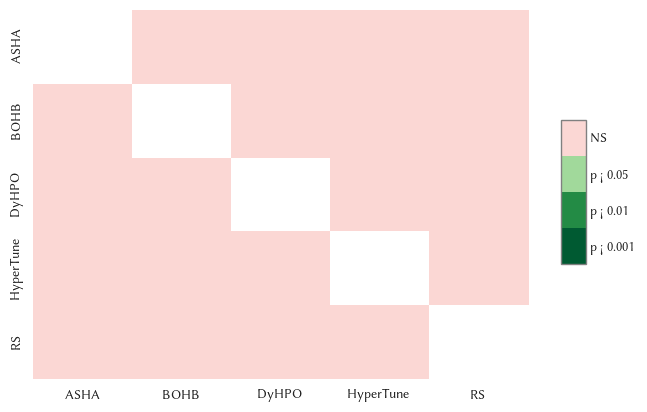

In [15]:
melted = means.melt(ignore_index=False, var_name='benchmark')
melted = melted.reset_index() # Reset index to get the algorithm column
melted = melted.astype({'value': 'float32'})
wilcoxon_results = sp.posthoc_wilcoxon(melted, val_col='value', group_col='algorithm', p_adjust='holm')
# Groups - datasets
# Val_col - algorithm - calculate differences between algorithms
print(wilcoxon_results)
sp.sign_plot(wilcoxon_results)

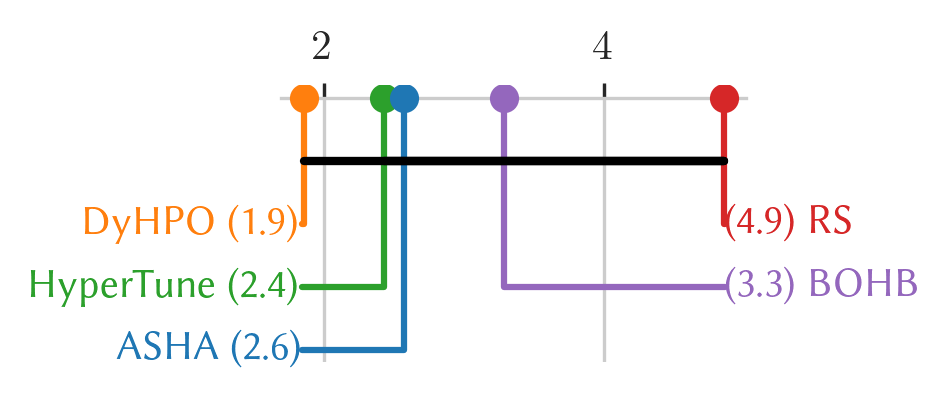

In [16]:
# CD real world
plt.figure(figsize=(2, 1.2), dpi=300)
#plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(ranks.mean(axis=1), wilcoxon_results, color_palette=colors)
plt.rcParams['savefig.format'] = 'pdf'
plt.savefig('../../thesis/img/real_exp/cd_diagram_real', bbox_inches='tight')

In [17]:
# 2. Calculate ranks for each benchmark at specific budget
benchmark_names = df.index.get_level_values('benchmark').unique().tolist()
algos = df.index.get_level_values('algorithm').unique()

frac = 0.5
avgs = []
ranks = []
means = []
for benchmark_name in benchmark_names:
    print(f"Calculating {benchmark_name}")
    bench_df = df.loc[(benchmark_name, algos, slice(None), slice(None))]
    bench_df = bench_df.reset_index(level='trial')

    budget = bench_df['max_num_evaluations'].iloc[0]

    # Calculate cumulative metric and ranks
    filtered = bench_df[bench_df['trial'] == frac * budget]
    ranks_df = filtered.groupby('algorithm')['cumulative'].mean().rank(ascending=False)
    ranks_df.rename(f'{benchmark_name}', inplace=True)
    cum_mean = filtered.groupby('algorithm')['regret'].mean()
    cum_mean.rename(f'{benchmark_name}', inplace=True)
    ranks.append(ranks_df)
    means.append(cum_mean)
ranks = pd.concat(ranks, axis=1)
means = pd.concat(means, axis=1)

#means
ranks

Calculating cifar10_residual
Calculating cifar10_simple
Calculating ptbxl_rnn
Calculating ptbxl_xResNet1d
Calculating svhn_residual
Calculating svhn_simple
Calculating xray_densenet


,cifar10_residual,cifar10_simple,ptbxl_rnn,ptbxl_xResNet1d,svhn_residual,svhn_simple,xray_densenet
algorithm,,,,,,,
ASHA,1.0,3.0,2.0,2.0,3.0,3.0,2.0
BOHB,5.0,4.0,5.0,4.0,4.0,4.0,5.0
DyHPO,4.0,1.0,3.0,3.0,1.0,2.0,1.0
HyperTune,2.0,2.0,1.0,1.0,2.0,1.0,3.0
RS,3.0,5.0,4.0,5.0,5.0,5.0,4.0


In [18]:
np_means = means.to_numpy()
friedman_stat, p_value = ss.friedmanchisquare(*np_means)
print(f"Friedman test statistic: {friedman_stat}, p-value: {p_value}")

Friedman test statistic: 19.542857142857144, p-value: 0.0006146045866527132


              ASHA     BOHB    DyHPO  HyperTune       RS
ASHA       1.00000  0.15625  1.00000    1.00000  0.15625
BOHB       0.15625  1.00000  0.15625    0.15625  0.87500
DyHPO      1.00000  0.15625  1.00000    1.00000  0.15625
HyperTune  1.00000  0.15625  1.00000    1.00000  0.15625
RS         0.15625  0.87500  0.15625    0.15625  1.00000


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x154e1fc4a60>)

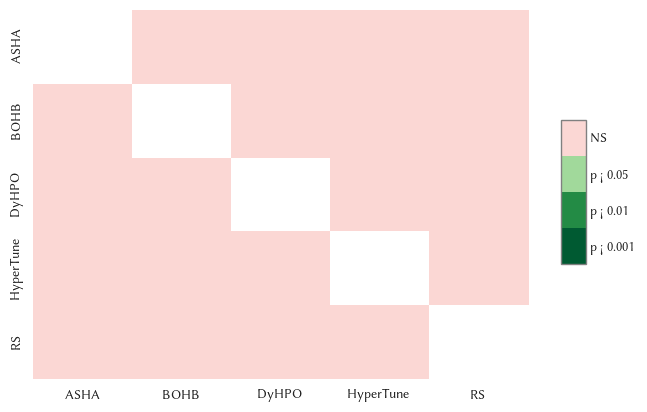

In [19]:
melted = means.melt(ignore_index=False, var_name='benchmark')
melted = melted.reset_index() # Reset index to get the algorithm column
melted = melted.astype({'value': 'float32'})
wilcoxon_results = sp.posthoc_wilcoxon(melted, val_col='value', group_col='algorithm', p_adjust='holm')
# Groups - datasets
# Val_col - algorithm - calculate differences between algorithms
print(wilcoxon_results)
sp.sign_plot(wilcoxon_results)

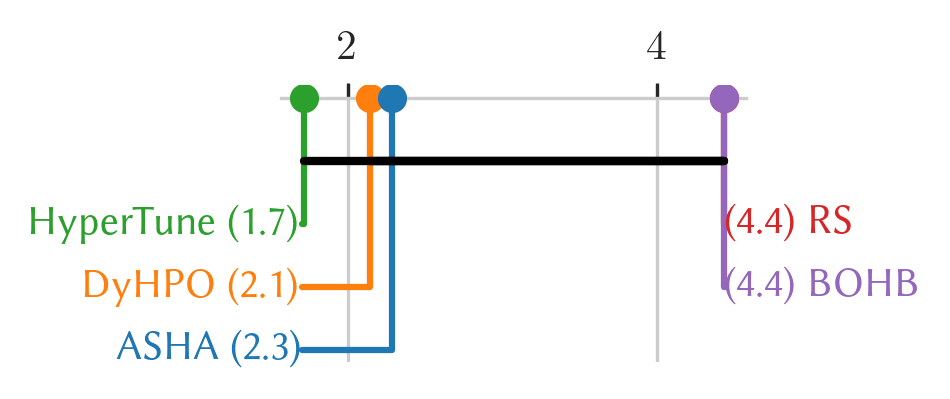

In [20]:

# CD real world 0.5
plt.figure(figsize=(2, 1.2), dpi=300)
#plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(ranks.mean(axis=1), wilcoxon_results, color_palette=colors)
plt.rcParams['savefig.format'] = 'pdf'
plt.savefig('../../thesis/img/real_exp/cd_diagram_real_half', bbox_inches='tight')